# Definición de Perfiles de Comprador

## Objetivo

En el siguiente notebook se buscará dar cumplimiento al objetivo de analítica 2 de nuestro portafolio de soluciones de analítica para LÍMPIK:

> **2**. Construir un modelo de clasificación de clientes acorde a los artículos que adquiere para generar perfiles de compradores*

**Modelo a usar:**  K-Means

Para dar cumplimiento a nuestro objetivo, realizaremos el siguiente paso a paso:

0. Importación de librerías necesarias
1. Carga de información limpia
2. Creación de un modelo
3. Evaluación / Métricas
4. Resultados

## 0. Importación de librerías necesarias

A continuación se traen todas las librerías necesarias para el desarrollo del modelo. A medida que se avance en el desarrollo, se realizarán los imports adicionales que sean necesarios

In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np            

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler       

from copy import deepcopy

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import confusion_matrix

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer  

## 1. Carga de información limpia

Para la elaboración del modelo de clustering KMeans, se trabajará con los datos procesados en el análisis exploratorio 

In [23]:
df = pd.read_csv('../../datos/clean_marketing_campaing.csv')
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines               float64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

### Transformaciones sobre los datos

En vista de que existen atributos que no son de utilidad para la construcción del modelo de predicción, se eliminarán estas del Dataframe.

Atributos a eliminar:
- ID
- AcceptedCmp1
- AcceptedCmp2
- AcceptedCmp3
- AcceptedCmp4
- AcceptedCmp5

In [72]:
df_clean = deepcopy(df)
df_clean.drop(['ID', 'AcceptedCmp1', 'AcceptedCmp2', 
               'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 
               'Z_CostContact', 'Z_Revenue'], 
              inplace=True, axis=1)

Igualmente, es neceario transformar atributos como 'Year_Birt' por la edad en particular, al igual que discretizar elementos como la educación. 

In [73]:
def calculate_age(birth_date_str: int):
    return 2020 - birth_date_str

In [74]:
df_clean['Age'] = df_clean.apply(lambda row: calculate_age(row['Year_Birth']), 
                                 axis=1)

df_clean.drop('Year_Birth', inplace=True, axis=1)

Podemos ver que también contamos con algunas variables categóricas que deben ser discretizadas: Education y Marital_Status

In [75]:
original_values_education = list(df_clean['Education'].unique())
original_values_marital = list(df_clean['Marital_Status'].unique())

new_values_education = list(range(1, len(original_values_education)+1))
new_values_marital = list(range(1, len(original_values_marital)+1))

df_clean['Marital_Status'].replace(original_values_marital, new_values_marital,inplace=True)
df_clean['Education'].replace(original_values_education, new_values_education,inplace=True)

print(df_clean[['Marital_Status', 'Education']])

      Marital_Status  Education
0                  1          1
1                  1          1
2                  2          1
3                  2          1
4                  3          2
...              ...        ...
2235               3          1
2236               2          2
2237               4          1
2238               2          3
2239               3          2

[2240 rows x 2 columns]


Solo nos restaría transformar Dt_Customer a días:

In [76]:
from datetime import date

def calculate_days(date_str: str):
    today = date(2020, 10, 23)
    
    date_array = date_str.split('-') 
    initial_date = date(int(date_array[0]), 
                      int(date_array[1]), 
                      int(date_array[2]))
    
    return int((today - initial_date).days)

In [77]:
df_clean['Enrolment_Days'] = df_clean.apply(lambda row: calculate_days(row['Dt_Customer']), 
                                 axis=1)

df_clean.drop('Dt_Customer', inplace=True, axis=1)

Con ello hemos generado un dataframe con tipos válidos para utilizar K-Means.

In [78]:
df_clean.dtypes

Education                int64
Marital_Status           int64
Income                 float64
Kidhome                  int64
Teenhome                 int64
Recency                  int64
MntWines               float64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Complain                 int64
Response                 int64
Age                      int64
Enrolment_Days           int64
dtype: object

## 2. Creación de un modelo

En vista de que buscaremos generar el modelo que mejor se adapte a nuestros datos, vamos a definir una función que genere construya un modelo K-Means a corde a un grupo de parámetros definidos.

In [79]:
def create_KMeans(k, kmin, kmax, init, n_init, max_iter, random_seed):
    kmeans = KMeans(n_clusters   = k,
                  init         = init,
                  n_init       = n_init,
                  max_iter     = max_iter,
                  random_state = random_seed)
    
    return kmeans

### Entrenamiento de modelos

Con nuestra función definida nos restaría entrenar diferentes modelos para diferentes valores de K. Para este caso vamos a entrenar para valores de $K = 1$ hasta $K = 15$.

Empezamos definiendo algunas constantes para cada modelo y el valor mínimo y máximo de $K$.

In [80]:
kmin = 1
kmax = 15          
init ='k-means++'
n_init = 10
max_iter = 400
random_seed = 42

### Evaluación de diferentes modelos

Ahora usaremos la silueta, el método del codo y el índice de Calinski-Harabasz para determinar el mejor $K$ para la creación de un modelo

In [81]:
def evaluate_models(data, kmin, kmax, init, n_init, max_iter, random_seed):
    
    model = KMeans(init=init, 
                    n_init=n_init, 
                    max_iter=max_iter, 
                    random_state=random_seed)

    for metric in ["distortion", "silhouette", "calinski_harabasz"]:

        if metric=="silhouette" or metric=="calinski_harabasz":  
            kmin_ = max(2,kmin)
        else:
            kmin_ = kmin

        plt.figure(figsize=(10,5))
        visualizer = KElbowVisualizer(estimator=model, 
                                      k=(kmin_,kmax+1),
                                      metric=metric,
                                      timings=False,          
                                      locate_elbow=True)
        visualizer.fit(data)
        visualizer.show()

A continuación se presentan las gráficas relacionadas a los estimadores mencionados.

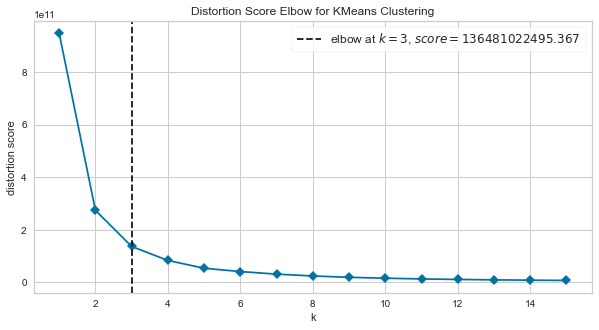

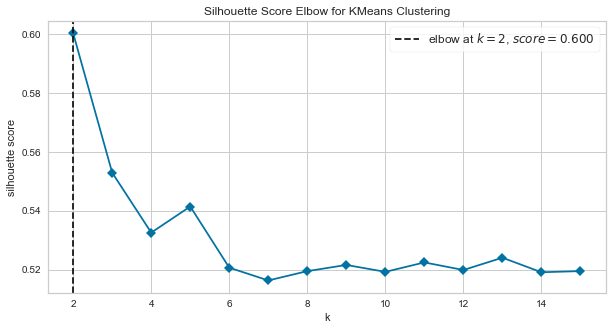

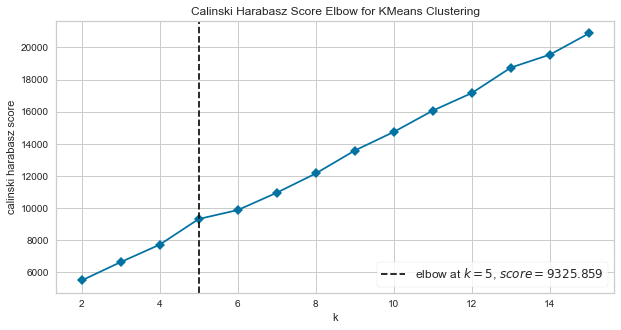

In [101]:
evaluate_models(df_clean, kmin, kmax, init, n_init, max_iter, random_seed)

En vista de que nuestros estimados no arrojan ningún K en común, vamos a evaluar los tres valores de $K$ propuestos: $K = 2$, $K = 3$ Y $K = 5$ por medio de las gráficasd e la silueta.

In [83]:
possible_k = [2, 3, 5]

For k clusters = 2 The average silhouette_score is : 0.6003384560716498


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


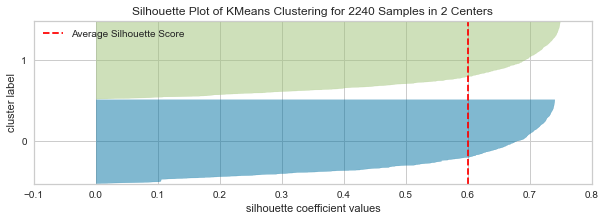

For k clusters = 3 The average silhouette_score is : 0.5529366495938964


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


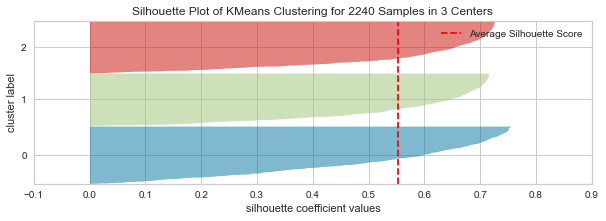

For k clusters = 5 The average silhouette_score is : 0.54144072711449


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


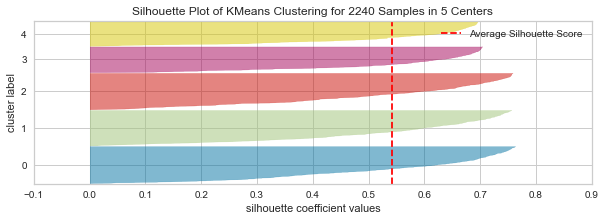

In [102]:
silhouette_score_list = []

for k in possible_k:
    model_K = create_KMeans(k, kmin, kmax, init, n_init, max_iter, random_seed)
    model_K.fit(df_clean)
    
    sc = silhouette_score(df_clean.values, model_K.labels_)
    silhouette_score_list.append(sc)
    
    print(
        "For k clusters =",
        k,
        "The average silhouette_score is :",
        sc,
    )
    plt.figure(figsize=(10,3))  #Tamaño de la figura (ancho, alto).
    visualizer2 = SilhouetteVisualizer(estimator=model_K, colors='yellowbrick')
    visualizer2.fit(df_clean)
    visualizer2.show() 

Con base en las gráficas anteriores se empleará el valor de $K = 3$ para la construcción de modelo.

### Modelo Seleccionado

Ahora, entrenaremos el modelo seleccionado.

In [85]:
k = 3

#Entrenamiento del modelo
kmeans_model = create_KMeans(k, kmin, kmax, init, n_init, max_iter, random_seed)
kmeans_model.fit(df_clean)

KMeans(max_iter=400, n_clusters=3, random_state=42)

Si deseamos visualziar los centroides de nuestro modelo, nos encontramos con lo siguiente:

In [86]:
#Centroides
kmeans_model.cluster_centers_

array([[1.95591940e+00, 2.55163728e+00, 5.16785038e+04, 4.23173804e-01,
        8.04785894e-01, 4.98488665e+01, 2.67354534e+02, 1.17858942e+01,
        8.82329975e+01, 1.80869018e+01, 1.20944584e+01, 3.18362720e+01,
        2.60327456e+00, 4.54030227e+00, 2.12090680e+00, 5.85894207e+00,
        5.66372796e+00, 5.03778338e-03, 1.02015113e-01, 5.36788413e+01,
        2.66946725e+03],
       [2.13406293e+00, 2.39945280e+00, 2.81865732e+04, 8.11217510e-01,
        3.07797538e-01, 4.83556772e+01, 2.99247606e+01, 5.35157319e+00,
        2.31532148e+01, 7.72093023e+00, 5.38577291e+00, 1.52270862e+01,
        2.00273598e+00, 2.09302326e+00, 4.89740082e-01, 3.07387141e+00,
        6.78248974e+00, 1.64158687e-02, 1.16279070e-01, 4.68153215e+01,
        2.66168399e+03],
       [1.85594406e+00, 2.53566434e+00, 7.55441427e+04, 9.23076923e-02,
        3.77622378e-01, 4.90587413e+01, 5.67518881e+02, 2.61818182e+01,
        2.31327273e+02, 3.87958042e+01, 2.44713287e+01, 4.31132867e+01,
        1.5216

Como se puede ver, no resulta posible graficar los clusters realizados para los perfiles de comprador, porque nuestras categorías se encuentran en $R^{20}$

## 3. Evaluación

<!-- ## 3. Evaluación -->

In [112]:
print('Inercia: ', kmeans_model.inertia_, '\n',
     '# clusters: ', kmeans_model.n_clusters, '\n')

Inercia:  136481022495.36588 
 # clusters:  3 



El modelo que hemos escodigo presenta una silueta promedio de $0.55$, una inercia de $136481022495.36588$ y un conjunto de $3$ clusters que son nuetros $3$ perfiles de compradores.

## 4. Resultados

Con los clusters obtenidos solo nos resta caracterizarlos para poder darles una mejor interpretación. Para ello añadimos a los datos la columna de Profile, en donde se va a encontrar el perfil de comprador de un cliente.

In [113]:
df_clean['Profile'] = kmeans_model.predict(df_clean)
df_clean['Profile']

0       0
1       0
2       2
3       1
4       0
       ..
2235    0
2236    2
2237    0
2238    2
2239    0
Name: Profile, Length: 2240, dtype: int32

A continuación podemos ver algunas de las estadísticas básicas de esta nueva columna

In [119]:
df_clean['Profile'].describe()

count    2240.000000
mean        0.964732
std         0.820193
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: Profile, dtype: float64

Ahora, por medio de gráficas, vamos a ver cómo estás dsitribuidos nuestros perfiles de comprador

### Perfil más frecuente 

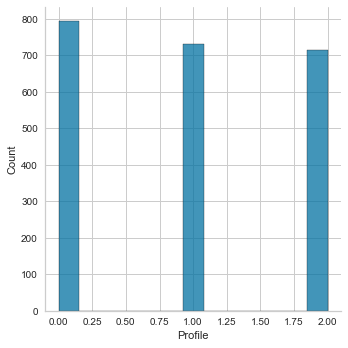

In [120]:
sns.displot(data=df_clean, x='Profile')

El **perfil que más se repite** es el perfil 0.

### Características de cada perfil

Ahora podemos verificar si existe alguna relación entre el perfil de comprador y los ingresos del mismo

#### Ingresos 

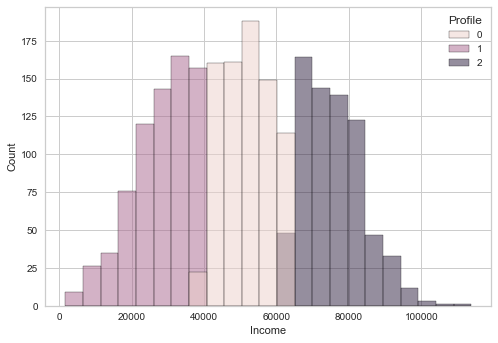

In [121]:
sns.histplot(data=df_clean, x='Income', hue='Profile')

Como nos muestra la gráfica, encontramos que los ingresos de nuestros perfiles comprador se encuentran destribuidos de la siguiente manera:

- 0: Ingresos entre 0 y 40.000 dólares
- 1: Ingresos entre 40.000 y 60.000 dólares
- 2: Ingresos entre 60.000 y un millón de dólares

#### Productos Adquiridos 

También podemos relacionar los perfiles de compradores con los diferentes productos que ofrece LÍMPIK: Vinos, frutas, carnes, pescados, dulces y accesorios en oro.

##### Vinos

Con esta gráfica podemos ver que el perfil 1 no consume mucho alcohol, a comparación de los perfiles 0 y 2, quienes sí invierten más dinero en la compra de este producto.

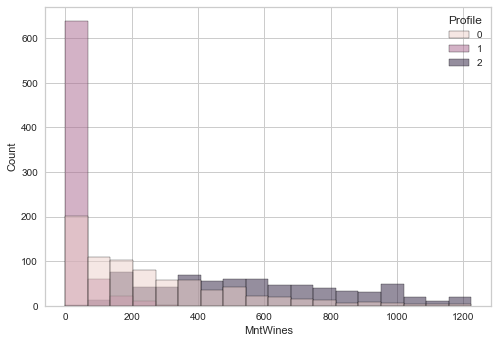

In [130]:
sns.histplot(data=df_clean, x='MntWines', hue='Profile')

##### Frutas

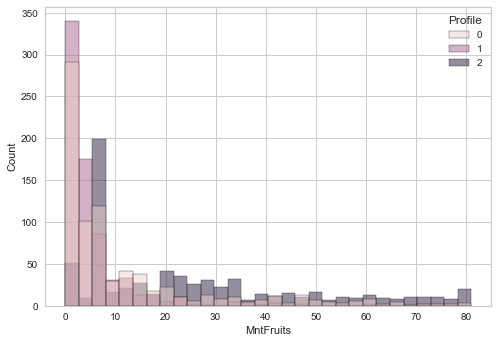

In [131]:
sns.histplot(data=df_clean, x='MntFruits', hue='Profile')

##### Carnes

De esta gráfica podemos extrar que el perfil 1 es el que menos carnes consume, mientras que el 2 es quién más productos de carnes compra.

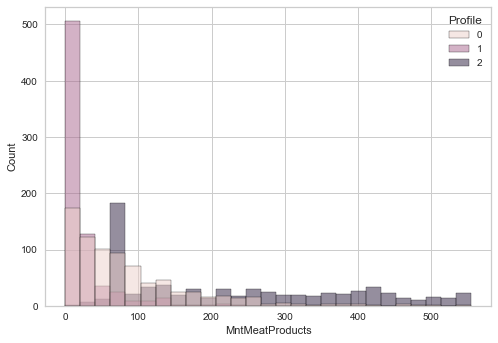

In [132]:
sns.histplot(data=df_clean, x='MntMeatProducts', hue='Profile')

##### Pescados 

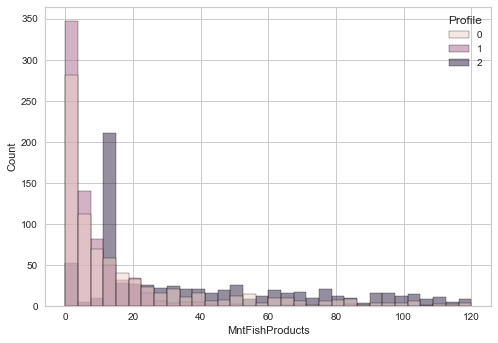

In [133]:
sns.histplot(data=df_clean, x='MntFishProducts', hue='Profile')

##### Dulce 

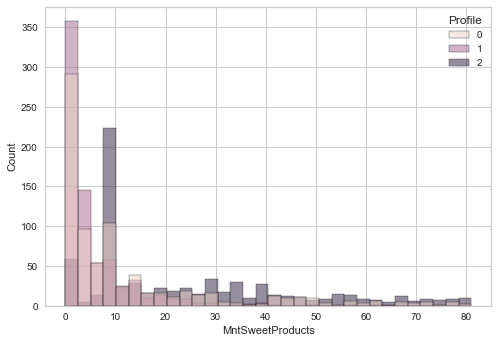

In [134]:
sns.histplot(data=df_clean, x='MntSweetProducts', hue='Profile')

##### Accesorios de oro 

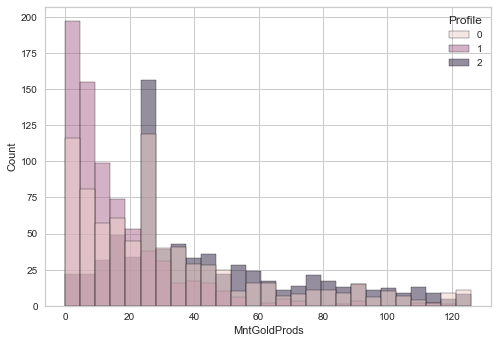

In [135]:
sns.histplot(data=df_clean, x='MntGoldProds', hue='Profile')

#### Descuentos

En la siguiente gráfica podemos el número de compras con descuento hechas por cada perfil

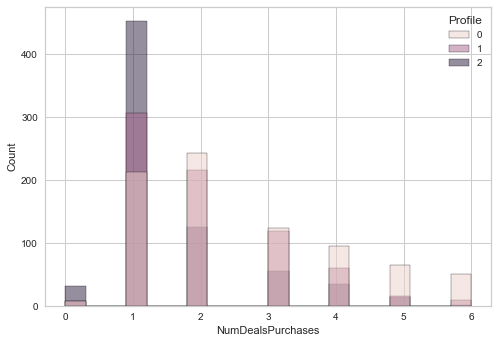

In [136]:
sns.histplot(data=df_clean, x='NumDealsPurchases', hue='Profile')

Si realizamos un conteno más a fondo de lo que sucede en la anterior gráfica y la tabla siguiente, nos encontramos con lo siguiente: 
- El perfil 0 es quien más realiza compras con descuento: 787 compras (aprox. el 99.11% de sus compras)
- Seguidamente está el 1 con 724 compras (99.04% de sus compras)
- Finalmente está elperfil 2 con 713 compras (99.7% de sus compras)

Dejando así que el 35% de las compras con descuento de LÍMPIK son hechas por clientes del perfil 0, 32% por clientes de perfil 1 y 32% por clientes de perfil 2.

In [153]:
print(df_clean.groupby('Profile')['NumDealsPurchases'].value_counts())

Profile  NumDealsPurchases
0        2                    243
         1                    212
         3                    123
         4                     95
         5                     64
         6                     50
         0                      7
1        1                    306
         2                    215
         3                    118
         4                     60
         5                     16
         6                      9
         0                      7
2        1                    452
         2                    125
         3                     56
         4                     34
         0                     32
         5                     14
         6                      2
Name: NumDealsPurchases, dtype: int64


#### Medio para realizar compras

A continuación se presentan las distribuciones de cada perfil por cada medio de compra con los que cuenta LÍMPIK: Página web, catálogo y tienda física.

##### Página Web

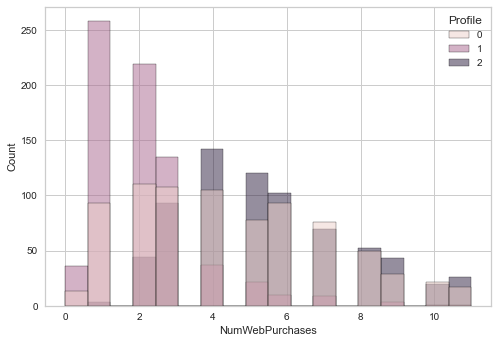

In [137]:
sns.histplot(data=df_clean, x='NumWebPurchases', hue='Profile')

In [163]:
print('Compras Hechas','\n',df_clean.groupby('Profile')['NumWebPurchases'].count(),'\n')
print('---'*15)
print('Distribución','\n', df_clean.groupby('Profile')['NumWebPurchases'].value_counts())


Compras Hechas 
 Profile
0    794
1    731
2    715
Name: NumWebPurchases, dtype: int64 

---------------------------------------------
Distribución 
 Profile  NumWebPurchases
0        2                  110
         3                  108
         4                  105
         1                   93
         6                   93
         5                   78
         7                   76
         8                   50
         9                   29
         10                  22
         11                  17
         0                   13
1        1                  258
         2                  219
         3                  135
         4                   37
         0                   36
         5                   22
         6                   10
         7                    9
         9                    3
         10                   1
         11                   1
2        4                  142
         5                  120
         6              

##### Catalogo

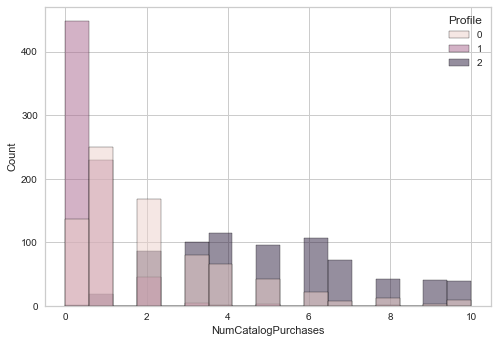

In [138]:
sns.histplot(data=df_clean, x='NumCatalogPurchases', hue='Profile')

In [166]:
print('Compras Hechas','\n',df_clean.groupby('Profile')['NumCatalogPurchases'].count(),'\n')
print('---'*15)
print(df_clean.groupby('Profile')['NumCatalogPurchases'].value_counts())

Compras Hechas 
 Profile
0    794
1    731
2    715
Name: NumCatalogPurchases, dtype: int64 

---------------------------------------------
Profile  NumCatalogPurchases
0        1                      249
         2                      168
         0                      137
         3                       80
         4                       66
         5                       42
         6                       22
         8                       12
         10                       9
         7                        7
         9                        2
1        0                      448
         1                      229
         2                       45
         3                        4
         5                        3
         4                        1
         8                        1
2        4                      115
         6                      106
         3                      100
         5                       95
         2                       86
   

##### Tienda Física 

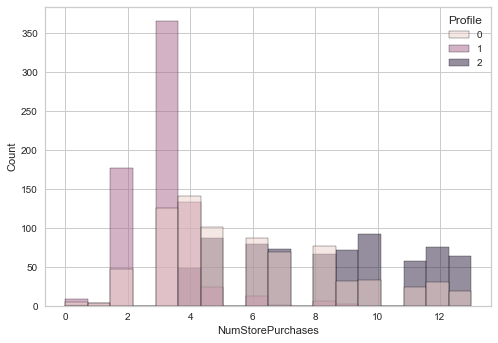

In [139]:
sns.histplot(data=df_clean, x='NumStorePurchases', hue='Profile')

In [164]:
print('Compras Hechas','\n',df_clean.groupby('Profile')['NumStorePurchases'].count(),'\n')
print('---'*15)
print(df_clean.groupby('Profile')['NumStorePurchases'].value_counts())

Compras Hechas 
 Profile
0    794
1    731
2    715
Name: NumStorePurchases, dtype: int64 

---------------------------------------------
Profile  NumStorePurchases
0        4                    141
         3                    125
         5                    101
         6                     87
         8                     77
         7                     69
         2                     47
         10                    33
         9                     32
         12                    30
         11                    24
         13                    19
         0                      5
         1                      4
1        3                    365
         2                    176
         4                    133
         5                     24
         6                     12
         0                      9
         8                      6
         1                      3
         9                      2
         7                      1
2        10        

De estos gráficos podemos extraer que el perfil 1 prefiere realizar sus compras en la tienda física, mientras que el 0 y el 2 realizan mayoritariamente compras por página web 

#### Visitas a web

Con la siguiente gráfica podemos ver que quien más revisa la página web es el perfil 1.

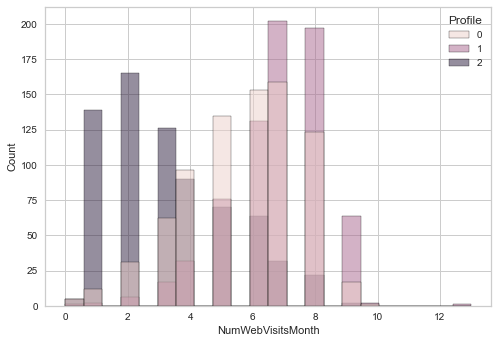

In [142]:
sns.histplot(data=df_clean, x='NumWebVisitsMonth', hue='Profile')

****

### Especificación final de cada perfil

+ Perfil 0: El pefil 0 es un cliente promedio, sus ingresos están entre 40.000 y 60.000 dólares. Adquiere en diferentes cantidades los productos del comercio, pero sin presentar un enfoque en particular. Es un perfil que prefiere realizar sus compras por la página web del comercio, en lugar del catálogo y de la tienda física.

+ Perfil 1:Este comprador presenta ingresos bajos, entre 0 y 40.000 dólares. No es un comprador que gaste mucho su dinero en los productos del comercio, es quien menos productos adquiere dentro de la población de clientes. Además de que a pesar de que frecuenta mucho la página web de LÍMPIK, prefiere realizar sus compras en el punto físico.

+ Perfil 2: Podemos identificar a estos compradores como una persona que cuenta con altos ingresos, más de 60.000 mil dólares. También este comprador se caracteriza por sus constantes gastos en productos como alcohol (vino) y diferentes productos del comercio como carnes, pescado y accesorios de Oro. Igualmente, este perfil prefiere realizar sus comprar por internet.